In [2]:
import math
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

In [3]:
symbols = ['XLE','XLU','XLK','XLB','XLP','XLY','XLI','XLV','XLF']
sector = ['Energy','Utilities','Technology','Materials','Consumer Staples','Consumer Discretionary',
         'industrials','Health Care','Financials']

start = pd.Timestamp('2010-01-01')
end = pd.Timestamp('2022-09-30')

etfs = yf.download(symbols,start,end)['Adj Close']
spy = yf.download(['SPY'],start,end)['Adj Close']

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
return_etfs = etfs.pct_change().dropna()
return_spy = spy.pct_change().dropna()

In [5]:
return_etfs

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2010-01-05,0.003233,0.008162,0.018380,0.003531,-0.001289,0.000375,-0.011905,-0.009807,0.003667
2010-01-06,0.016994,0.011975,0.002006,0.002111,-0.011188,-0.000750,0.005861,0.010224,0.001329
2010-01-07,-0.007779,-0.001500,0.021347,0.010885,-0.003916,0.000000,-0.004532,0.003479,0.008292
2010-01-08,0.013937,0.006510,-0.005879,0.015977,0.006553,-0.003376,-0.000976,0.001576,-0.000329
2010-01-11,-0.005441,-0.001327,0.000657,0.010941,-0.003906,0.002634,0.010417,0.005664,-0.001974
...,...,...,...,...,...,...,...,...,...
2022-09-23,-0.020470,-0.068956,-0.015848,-0.018757,-0.013080,-0.017002,-0.011570,-0.005107,-0.023020
2022-09-26,-0.016221,-0.024546,-0.015781,-0.010501,-0.006950,0.000721,-0.024108,-0.009533,-0.002254
2022-09-27,0.002228,0.011200,-0.004254,-0.003339,0.001302,-0.017284,-0.016850,-0.003044,0.003149


In [6]:
return_etfs.shape[0]

3207

In [7]:
bf_day=3207

In [8]:
# sigma_m = stock_cov
import scipy.optimize as sco
# from scipy.optimize import minimize

def objective(weights): 
    weights = np.array(weights)
    stock_cov_2 = return_etfs.cov() * bf_day
    return weights.dot(stock_cov_2).dot(weights.T)


cons = ({"type":"eq", "fun": lambda x: np.sum(x)-1})
# Every stock can get any weight from -1 to 1
bounds = tuple((-1,1) for x in range(return_etfs.shape[1])) 


# Initialize the weights with an even split
# In out case each stock will have 10% at the beginning
guess = [1./return_etfs.shape[1] for x in range(return_etfs.shape[1])]

In [9]:
optimized_results = sco.minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
optimized_results

     fun: 0.2348773962394212
     jac: array([0.46950235, 0.47008601, 0.46941388, 0.46995582, 0.46946456,
       0.46967955, 0.46988058, 0.4695417 , 0.46975935])
 message: 'Optimization terminated successfully'
    nfev: 130
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([-0.0260997 ,  0.03245827, -0.16044157, -0.03426467, -0.12986182,
        0.75504151,  0.11269287,  0.28601166,  0.16446345])

In [10]:
pd.DataFrame(list(zip(return_etfs.columns, optimized_results.x)), columns=['Symbol', 'Weight'])

,Symbol,Weight
0,XLB,-0.026100
1,XLE,0.032458
2,XLF,-0.160442
3,XLI,-0.034265
4,XLK,-0.129862
5,XLP,0.755042
6,XLU,0.112693
7,XLV,0.286012
8,XLY,0.164463


In [11]:
return_spy_matrix=np.matrix(return_spy).reshape(-1,1)
spy=pd.DataFrame(return_spy_matrix, columns=['spy'])
spy

,spy
0,0.002647
1,0.000704
2,0.004221
3,0.003328
4,0.001397
...,...
3202,-0.016755
3203,-0.009893
3204,-0.002553
3205,0.019676


Text(0.5, 1.0, 'Distribution of SPY returns')

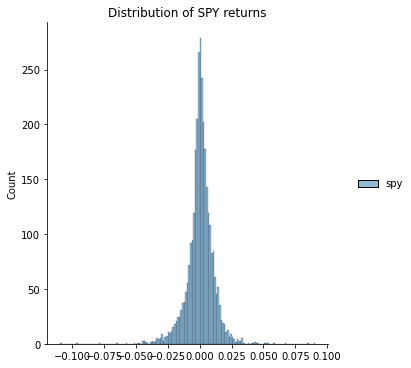

In [12]:
sns.displot(spy)
plt.title("Distribution of SPY returns")

Text(0.5, 1.0, 'Density of SPY')

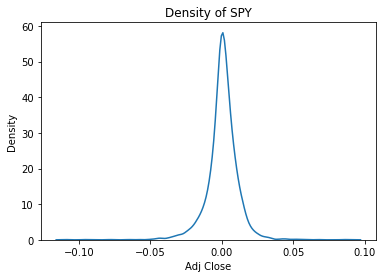

In [13]:
sns.kdeplot(return_spy)
plt.title("Density of SPY")

In [14]:
portfolio=np.matmul(np.matrix(return_etfs), np.array(optimized_results.x))
port=pd.DataFrame(portfolio.reshape(3207,-1),columns=['Portfolio'])
port

,Portfolio
0,-0.005982
1,0.004241
2,-0.001287
3,-0.002870
4,0.004584
...,...
3202,-0.016208
3203,-0.001849
3204,-0.014368
3205,0.016459


In [15]:
port.cumsum()

,Portfolio
0,-0.005982
1,-0.001742
2,-0.003029
3,-0.005899
4,-0.001314
...,...
3202,1.498771
3203,1.496922
3204,1.482554
3205,1.499012


In [16]:
print("SPY Cumsum Asset:",return_spy.cumsum()[-1]*1000000)

SPY Cumsum Asset: 1601328.408416149


In [17]:
#1508852.0017175123

In [18]:
def get_max_drawdown_fast(array):
    drawdowns = []
    max_so_far = array[0]
    for i in range(len(array)):
        if array[i] > max_so_far:
            drawdown = 0
            drawdowns.append(drawdown)
            max_so_far = array[i]
        else:
            drawdown = max_so_far - array[i]
            drawdowns.append(drawdown)
    return max(drawdowns)

In [19]:
get_max_drawdown_fast(list(port.values))[0]

0.14129272049975874

In [20]:
get_max_drawdown_fast(list(return_spy.values))

0.19490996455541743

In [21]:
data = pd.concat([spy,port], axis=1)
data.columns = ['spy','port']
data 

,spy,port
0,0.002647,-0.005982
1,0.000704,0.004241
2,0.004221,-0.001287
3,0.003328,-0.002870
4,0.001397,0.004584
...,...,...
3202,-0.016755,-0.016208
3203,-0.009893,-0.001849
3204,-0.002553,-0.014368
3205,0.019676,0.016459


In [22]:
data['spy'].loc[0]

0.0026469229402763528

In [23]:
return_etfs

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2010-01-05,0.003233,0.008162,0.018380,0.003531,-0.001289,0.000375,-0.011905,-0.009807,0.003667
2010-01-06,0.016994,0.011975,0.002006,0.002111,-0.011188,-0.000750,0.005861,0.010224,0.001329
2010-01-07,-0.007779,-0.001500,0.021347,0.010885,-0.003916,0.000000,-0.004532,0.003479,0.008292
2010-01-08,0.013937,0.006510,-0.005879,0.015977,0.006553,-0.003376,-0.000976,0.001576,-0.000329
2010-01-11,-0.005441,-0.001327,0.000657,0.010941,-0.003906,0.002634,0.010417,0.005664,-0.001974
...,...,...,...,...,...,...,...,...,...
2022-09-23,-0.020470,-0.068956,-0.015848,-0.018757,-0.013080,-0.017002,-0.011570,-0.005107,-0.023020
2022-09-26,-0.016221,-0.024546,-0.015781,-0.010501,-0.006950,0.000721,-0.024108,-0.009533,-0.002254
2022-09-27,0.002228,0.011200,-0.004254,-0.003339,0.001302,-0.017284,-0.016850,-0.003044,0.003149


In [24]:
return_etfs1=return_etfs.copy()
return_etfs1

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2010-01-05,0.003233,0.008162,0.018380,0.003531,-0.001289,0.000375,-0.011905,-0.009807,0.003667
2010-01-06,0.016994,0.011975,0.002006,0.002111,-0.011188,-0.000750,0.005861,0.010224,0.001329
2010-01-07,-0.007779,-0.001500,0.021347,0.010885,-0.003916,0.000000,-0.004532,0.003479,0.008292
2010-01-08,0.013937,0.006510,-0.005879,0.015977,0.006553,-0.003376,-0.000976,0.001576,-0.000329
2010-01-11,-0.005441,-0.001327,0.000657,0.010941,-0.003906,0.002634,0.010417,0.005664,-0.001974
...,...,...,...,...,...,...,...,...,...
2022-09-23,-0.020470,-0.068956,-0.015848,-0.018757,-0.013080,-0.017002,-0.011570,-0.005107,-0.023020
2022-09-26,-0.016221,-0.024546,-0.015781,-0.010501,-0.006950,0.000721,-0.024108,-0.009533,-0.002254
2022-09-27,0.002228,0.011200,-0.004254,-0.003339,0.001302,-0.017284,-0.016850,-0.003044,0.003149


In [25]:
data

,spy,port
0,0.002647,-0.005982
1,0.000704,0.004241
2,0.004221,-0.001287
3,0.003328,-0.002870
4,0.001397,0.004584
...,...,...
3202,-0.016755,-0.016208
3203,-0.009893,-0.001849
3204,-0.002553,-0.014368
3205,0.019676,0.016459


In [26]:
return_etfs1['spy']=data['spy'].values
return_etfs1['port']=data['port'].values
return_etfs1

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,spy,port
Date,,,,,,,,,,,
2010-01-05,0.003233,0.008162,0.018380,0.003531,-0.001289,0.000375,-0.011905,-0.009807,0.003667,0.002647,-0.005982
2010-01-06,0.016994,0.011975,0.002006,0.002111,-0.011188,-0.000750,0.005861,0.010224,0.001329,0.000704,0.004241
2010-01-07,-0.007779,-0.001500,0.021347,0.010885,-0.003916,0.000000,-0.004532,0.003479,0.008292,0.004221,-0.001287
2010-01-08,0.013937,0.006510,-0.005879,0.015977,0.006553,-0.003376,-0.000976,0.001576,-0.000329,0.003328,-0.002870
2010-01-11,-0.005441,-0.001327,0.000657,0.010941,-0.003906,0.002634,0.010417,0.005664,-0.001974,0.001397,0.004584
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-23,-0.020470,-0.068956,-0.015848,-0.018757,-0.013080,-0.017002,-0.011570,-0.005107,-0.023020,-0.016755,-0.016208
2022-09-26,-0.016221,-0.024546,-0.015781,-0.010501,-0.006950,0.000721,-0.024108,-0.009533,-0.002254,-0.009893,-0.001849
2022-09-27,0.002228,0.011200,-0.004254,-0.003339,0.001302,-0.017284,-0.016850,-0.003044,0.003149,-0.002553,-0.014368


In [27]:
return_etfs

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2010-01-05,0.003233,0.008162,0.018380,0.003531,-0.001289,0.000375,-0.011905,-0.009807,0.003667
2010-01-06,0.016994,0.011975,0.002006,0.002111,-0.011188,-0.000750,0.005861,0.010224,0.001329
2010-01-07,-0.007779,-0.001500,0.021347,0.010885,-0.003916,0.000000,-0.004532,0.003479,0.008292
2010-01-08,0.013937,0.006510,-0.005879,0.015977,0.006553,-0.003376,-0.000976,0.001576,-0.000329
2010-01-11,-0.005441,-0.001327,0.000657,0.010941,-0.003906,0.002634,0.010417,0.005664,-0.001974
...,...,...,...,...,...,...,...,...,...
2022-09-23,-0.020470,-0.068956,-0.015848,-0.018757,-0.013080,-0.017002,-0.011570,-0.005107,-0.023020
2022-09-26,-0.016221,-0.024546,-0.015781,-0.010501,-0.006950,0.000721,-0.024108,-0.009533,-0.002254
2022-09-27,0.002228,0.011200,-0.004254,-0.003339,0.001302,-0.017284,-0.016850,-0.003044,0.003149


In [28]:
print("Portfolio Cumsum Asset:",return_etfs1['port'].cumsum()[-1]*1000000)
print("SPY Cumsum Asset:",return_spy.cumsum()[-1]*1000000)

print("Portfolio Mean Asset",port.mean()*1000000)
print("SPY Mean Asset",return_spy.mean()*1000000)

print("Portfolio Sharpe Ratio:",port.mean()/port.std())
print("SPY Sharpe Ratio",return_spy.mean()/return_spy.std())

print("Portfolio Max Drawdown",get_max_drawdown_fast(list(port.values))[0])
print("SPY Max Drawdown",get_max_drawdown_fast(list(return_spy.values)))

Portfolio Cumsum Asset: 1480323.319807127
SPY Cumsum Asset: 1601328.408416149
Portfolio Mean Asset Portfolio    461.591306
dtype: float64
SPY Mean Asset 499.3228588762548
Portfolio Sharpe Ratio: Portfolio    0.053937
dtype: float64
SPY Sharpe Ratio 0.04546377315991613
Portfolio Max Drawdown 0.14129272049975874
SPY Max Drawdown 0.19490996455541743


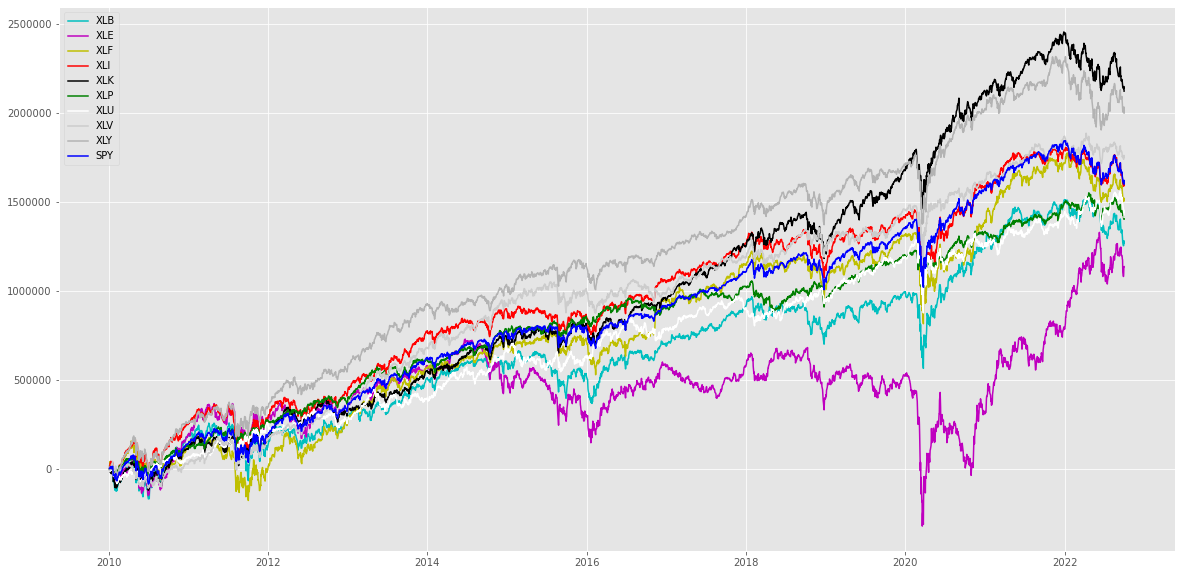

In [168]:
plt.figure(figsize=(20,10))
plt.ticklabel_format(style='plain')
plt.plot(return_etfs1['XLB'].cumsum()*1000000,color='c',label='XLB')
plt.plot(return_etfs1['XLE'].cumsum()*1000000,color='m',label='XLE')
plt.plot(return_etfs1['XLF'].cumsum()*1000000,color='y',label='XLF')

plt.plot(return_etfs1['XLI'].cumsum()*1000000,color='r',label='XLI')

plt.plot(return_etfs1['XLK'].cumsum()*1000000,color='k',label='XLK')
plt.plot(return_etfs1['XLP'].cumsum()*1000000,color='g',label='XLP')
plt.plot(return_etfs1['XLU'].cumsum()*1000000,color='w',label='XLU')
plt.plot(return_etfs1['XLV'].cumsum()*1000000,color='0.8',label='XLV')
plt.plot(return_etfs1['XLY'].cumsum()*1000000,color='0.7',label='XLY')
plt.plot(return_spy.cumsum()*1000000,color='b',label='SPY')
plt.legend()

In [30]:
import statsmodels.formula.api as smf
q = 0.5
q2 = 0.05
q3 = 0.95
mod = smf.quantreg("spy ~ port",data)
res = mod.fit(q)
res2 = mod.fit(q2)
res3 = mod.fit(q3)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    spy   Pseudo R-squared:               0.2866
Model:                       QuantReg   Bandwidth:                    0.001849
Method:                 Least Squares   Sparsity:                      0.01337
Date:                Tue, 29 Nov 2022   No. Observations:                 3207
Time:                        08:57:50   Df Residuals:                     3205
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0001      0.000      0.873      0.383      -0.000       0.000
port           0.8847      0.014     64.117      0.000       0.858       0.912


In [31]:
res.conf_int()

,0,1
Intercept,-0.000129,0.000335
port,0.857668,0.911778


In [32]:
models = [[q, res.params["Intercept"], res.params["port"]] + res.conf_int().loc["port"].tolist()]
models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])
models

,q,a,b,lb,ub
0,0.5,0.000103,0.884723,0.857668,0.911778


In [33]:
models2 = [[q2, res2.params["Intercept"], res2.params["port"]] + res2.conf_int().loc["port"].tolist()]
models2 = pd.DataFrame(models2, columns=["q", "a", "b", "lb", "ub"])
# models2
models3 = [[q3, res3.params["Intercept"], res3.params["port"]] + res3.conf_int().loc["port"].tolist()]
models3 = pd.DataFrame(models3, columns=["q", "a", "b", "lb", "ub"])
# models3

In [34]:
models2 

,q,a,b,lb,ub
0,0.05,-0.011097,1.068015,0.935081,1.200949


In [35]:
models3

,q,a,b,lb,ub
0,0.95,0.011374,0.920622,0.790251,1.050992


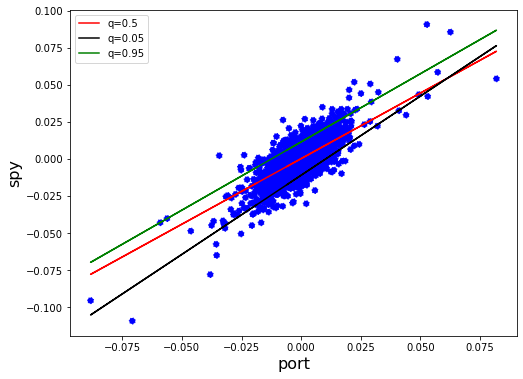

In [36]:
x = data.port
get_y = lambda a, b: a + b * x
fig, ax = plt.subplots(figsize=(8, 6))

y1 = get_y(models.a[0], models.b[0])
y2 = get_y(models2.a[0], models2.b[0])
y3 = get_y(models3.a[0], models3.b[0])
ax.plot(x, y1, color="red", label='q=0.5')
ax.plot(x, y2, color="black", label='q=0.05')
ax.plot(x, y3, color="green", label='q=0.95')

#ax.scatter(q2_etf.iloc[0:100,0], q2_spy.iloc[0:100], linestyle="dotted", color="blue")
ax.scatter(port, spy, linestyle="dotted", color="blue")
ax.set_xlabel("port", fontsize=16)
ax.set_ylabel("spy", fontsize=16)
ax.legend()

In [37]:
# 10day VaR = sqrt(10)* 1day VaR
roll = 10
a = 0.05
bf_day = 100
seq = int(a*bf_day)

In [38]:
etf_ret=return_spy ['2010-01-01':'2022-09-29']
etf_ret

Date
2010-01-05    0.002647
2010-01-06    0.000704
2010-01-07    0.004221
2010-01-08    0.003328
2010-01-11    0.001397
                ...   
2022-09-23   -0.016755
2022-09-26   -0.009893
2022-09-27   -0.002553
2022-09-28    0.019676
2022-09-29   -0.020889
Name: Adj Close, Length: 3207, dtype: float64

In [39]:
etf_ret.iloc[0:bf_day].sort_values()[4]

-0.023514638031263413

In [43]:
len_day=len(return_etfs)-roll
var_1 = np.zeros(len_day)
for i in range(len_day):
    td_var_1 = etf_ret.iloc[i:i+bf_day].sort_values()[seq-1]
    var_1[i] = td_var_1  
    
var_10 = var_1*np.sqrt(10)
var_10

array([-0.07435981, -0.07435981, -0.07435981, ..., -0.03629837,
       -0.03590217, -0.03590217])

Text(0.5, 0, 'Loss of money')

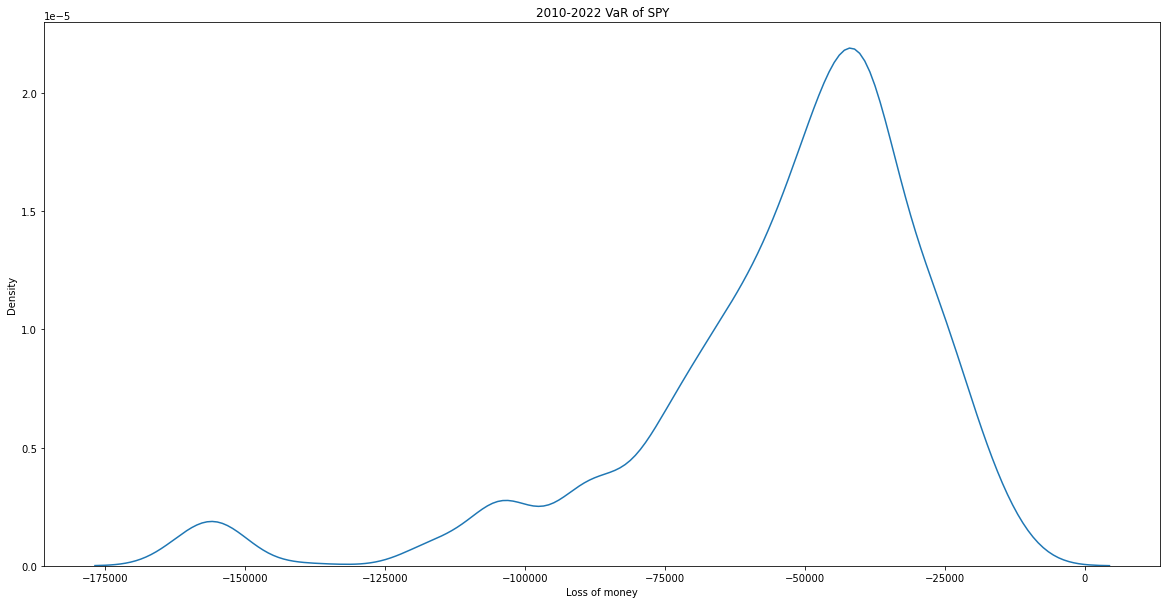

In [44]:
plt.figure(figsize=(20,10))
sns.kdeplot(var_10*1000000)
plt.title("2010-2022 VaR of SPY")
plt.xlabel("Loss of money")

In [45]:
num_etf = len(port.columns)
num_etf

1

In [46]:
len(return_etfs.columns)

9

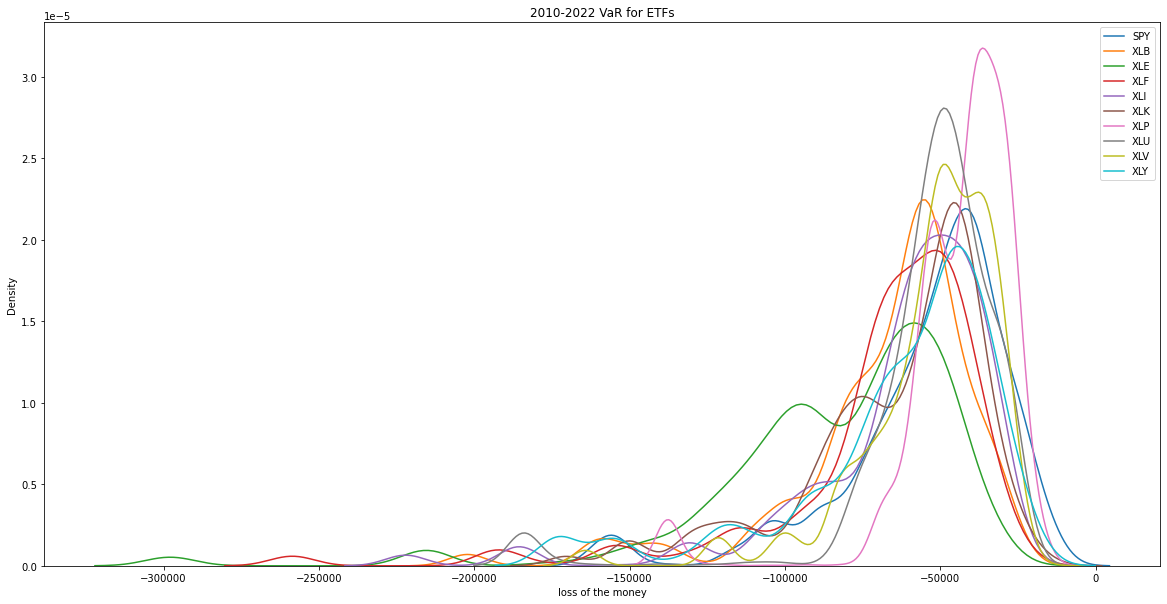

In [47]:
plt.figure(figsize=(20,10))

num_etf = len(return_etfs.columns)
var_etf_1 = np.zeros((len_day, num_etf))
for i in range(len_day):
    for j in range(num_etf):
        td_var_one_1 = return_etfs.iloc[i:i+bf_day,j].sort_values()[seq-1]
        var_etf_1[i,j] = td_var_one_1
var_etf_10 = var_etf_1*np.sqrt(10)
sns.kdeplot(var_10*1000000, label='SPY')
for i in range(num_etf):
    sns.kdeplot(var_etf_10[:,i]*1000000, label=return_etfs.columns[i])
plt.title('2010-2022 VaR for ETFs')
plt.xlabel("loss of the money")
plt.legend()

In [48]:
type(var_etf_10)

numpy.ndarray

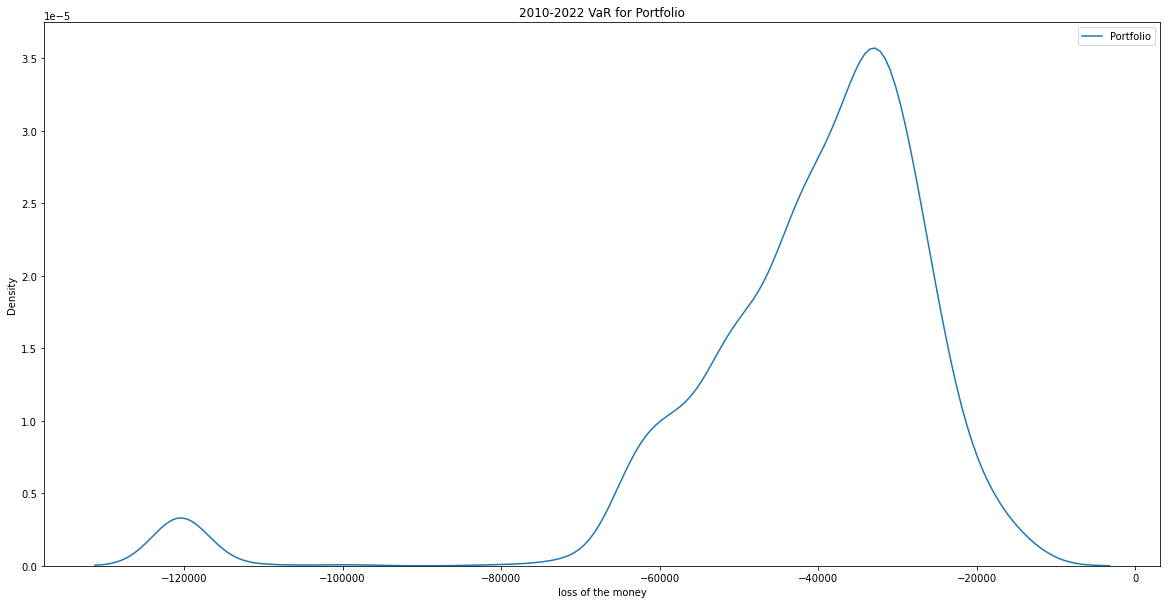

In [51]:
plt.figure(figsize=(20,10))
len_day=len(return_etfs)-roll
var_1 = np.zeros(len_day)
for i in range(len_day):
    td_var_1 = return_etfs1['port'].iloc[i:i+bf_day].sort_values()[seq-1]
    var_1[i] = td_var_1  
    
var_port_10 = var_1*np.sqrt(10)
var_port_10
sns.kdeplot(var_port_10*1000000, label='Portfolio')
plt.title('2010-2022 VaR for Portfolio')
plt.xlabel("loss of the money")
plt.legend()


-0.0731349321273389

In [52]:
VaR_port =  return_etfs1.iloc[:,0].sort_values()[seq-1]
CoVaR = res2.params['Intercept'] + res2.params['port']*VaR_port
CoVaR

-0.08920666347517169

In [53]:
#VaR_port =  return_etfs.iloc[0:bf_day,0].sort_values()[seq-1]
#CoVaR = res2.params['Intercept'] + res2.params['port']*VaR_port
#CoVaR

In [54]:
seq_50 = 50
VaR_port_50 =  return_etfs1['port'].iloc[:].sort_values()[seq_50-1]
CoVaR_50 = res2.params['Intercept'] + res2.params['port']*VaR_port_50
delta_CoVaR = CoVaR - CoVaR_50
delta_CoVaR*np.sqrt(252)*1000000

-905856.6740490057

In [55]:
#seq_50 = 50
#VaR_port_50 =  return_etfs['port'].iloc[0:,].sort_values()[seq_50-1]
#CoVaR_50 = res2.params['Intercept'] + res2.params['port']*VaR_port_50
#delta_CoVaR = CoVaR - CoVaR_50
#delta_CoVaR

In [56]:
return_etfs.shape[0]-bf_day

3107

In [57]:
num_etf = len(return_etfs)
num_etf

3207

In [58]:
return_etfs.shape[0]-bf_day

3107

In [61]:
bf_day

100

In [64]:
 len(return_etfs.columns)

9

In [74]:
res.params

Intercept   -1.734723e-18
XLY[0]       5.000000e-01
XLY[1]       5.000000e-01
dtype: float64

In [86]:
res.params[1]

0.4999999999999995

In [169]:
return_etfs.shape[0]-bf_day

3107

In [171]:
q = 0.05
len_day = return_etfs.shape[0]-10
num_etf = len(return_etfs.columns)
alpha_matrix = np.zeros((len_day,num_etf))
beta_matrix = np.zeros((len_day,num_etf))
for i in range(len_day):
    for j in range(num_etf):
        etf = return_etfs.iloc[i:i+10,j]
        data1 = pd.concat([return_etfs.iloc[i:i+10], etf], axis=1)
        mod = smf.quantreg("etf ~ "+etf.name, data1)
        res = mod.fit(q)
        alpha_matrix[i,j] = res.params['Intercept']
        beta_matrix[i,j] = res.params[1]
        
        

In [172]:
beta_matrix

array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]])

In [173]:
alpha_matrix

array([[ 0.00000000e+00, -5.20417043e-18, -2.16840434e-19, ...,
         8.67361738e-19,  0.00000000e+00,  0.00000000e+00],
       [ 6.93889390e-18,  6.93889390e-18, -5.42101086e-20, ...,
        -3.25260652e-19, -1.30104261e-18,  0.00000000e+00],
       [-8.67361738e-19, -4.33680869e-19, -6.93889390e-18, ...,
         1.04083409e-17, -1.73472348e-18, -4.33680869e-19],
       ...,
       [ 3.46944695e-18,  5.20417043e-18,  1.38777878e-17, ...,
        -8.67361738e-19,  1.38777878e-17,  6.93889390e-18],
       [ 9.71445147e-17, -3.46944695e-18, -5.20417043e-18, ...,
        -5.55111512e-17, -3.46944695e-18, -1.38777878e-17],
       [-5.20417043e-18,  1.73472348e-18, -2.60208521e-18, ...,
         1.73472348e-18, -3.46944695e-18,  0.00000000e+00]])

In [174]:
data1.shape

(10, 10)

In [175]:
var_etf_10

array([[-0.10984698, -0.08454999, -0.10719558, ..., -0.05436211,
        -0.05540925, -0.0914813 ],
       [-0.10984698, -0.08454999, -0.10719558, ..., -0.05436211,
        -0.05540925, -0.0914813 ],
       [-0.10984698, -0.09709659, -0.10719558, ..., -0.06949021,
        -0.05540925, -0.0914813 ],
       ...,
       [-0.05129519, -0.06746695, -0.04990388, ..., -0.05328414,
        -0.02655642, -0.07279541],
       [-0.04995068, -0.04634715, -0.04658777, ..., -0.04598281,
        -0.01703876, -0.05361452],
       [-0.04995068, -0.04634715, -0.04658777, ..., -0.04598281,
        -0.01703876, -0.05361452]])

In [176]:
var_10

array([-0.07435981, -0.07435981, -0.07435981, ..., -0.03629837,
       -0.03590217, -0.03590217])

In [177]:
var_port_10

array([-0.04255531, -0.04255531, -0.04255531, ..., -0.02556563,
       -0.02259444, -0.02259444])

In [178]:
num_etf

9

In [183]:
VaR_ETFS = np.zeros((len_day,num_etf))
CoVaR = np.zeros((len_day,num_etf))
for i in range(len_day):
    for j in range(num_etf):
        VaR_ETFS[i,j] = return_etfs1.iloc[i:i+10,j].sort_values()[seq-1]
        CoVaR[i,j] = alpha_matrix[i,j] + beta_matrix[i,j]*VaR_ETFS[i,j]

Text(0.5, 0, 'coVaR')

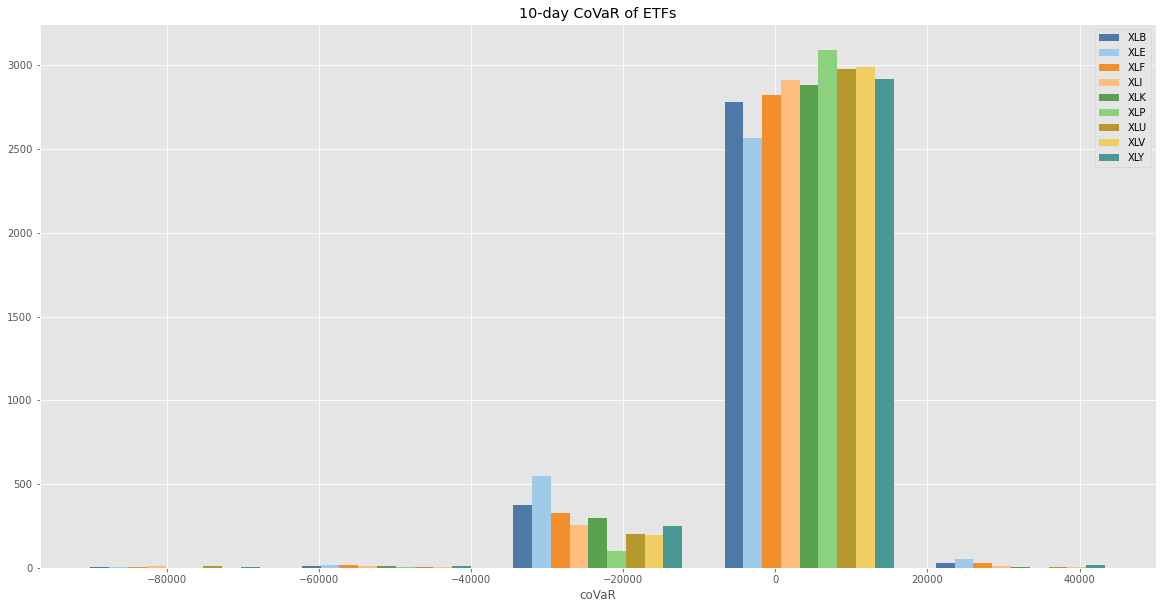

In [187]:
plt.figure(figsize=(20,10))
plt.style.use('ggplot')
plt.hist(CoVaR*np.sqrt(10)*1000000,bins = 5,label = return_etfs1.columns,
         color = ["#4E79A7", "#A0CBE8", "#F28E2B", "#FFBE7D", "#59A14F", "#8CD17D", 
                  "#B6992D", "#F1CE63", "#499894"])
plt.title("10-day CoVaR of ETFs")
plt.legend()
plt.xlabel("coVaR")

In [185]:
VaR_Port = np.zeros((len_day,num_etf))
CoVaR_Port = np.zeros((len_day,num_etf))
for i in range(len_day):
    VaR_Port[i] =  return_etfs1['port'].iloc[i:i+10].sort_values()[seq-1]
    CoVaR_Port[i] = alpha_matrix[i] + beta_matrix[i]*VaR_Port[i]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'coVaR')

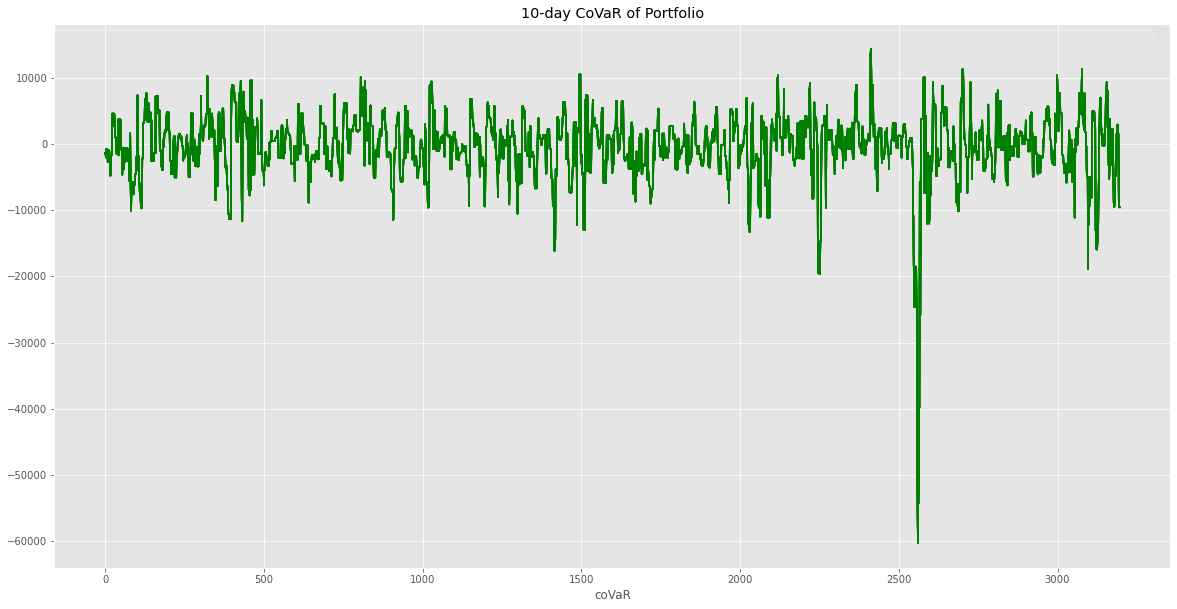

In [188]:
plt.figure(figsize=(20,10))
plt.plot(CoVaR_Port*np.sqrt(10)*1000000,color='g')
plt.title("10-day CoVaR of Portfolio")
plt.legend()
plt.xlabel("coVaR")

In [ ]:
# Change 10 to 100 calculate 100 day CoVaR

In [189]:
q = 0.05
len_day = return_etfs.shape[0]-100
num_etf = len(return_etfs.columns)
alpha_matrix = np.zeros((len_day,num_etf))
beta_matrix = np.zeros((len_day,num_etf))
for i in range(len_day):
    for j in range(num_etf):
        etf = return_etfs.iloc[i:i+100,j]
        data1 = pd.concat([return_etfs.iloc[i:i+100], etf], axis=1)
        mod = smf.quantreg("etf ~ "+etf.name, data1)
        res = mod.fit(q)
        alpha_matrix[i,j] = res.params['Intercept']
        beta_matrix[i,j] = res.params[1]

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx =

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kerne

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: i

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx =

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: inval

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in dou

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in tru

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in dou

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: i

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: i

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xt

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in dou

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: d

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in dou

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in mul

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in dou

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in dou

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fh

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fh

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: inval

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in tru

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fh

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in tru

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fh

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in tru

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. /

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in dou

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: inval

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in tru

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: inval

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: i

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in dou

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: i

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: d

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in tru

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in tru

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in dou

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fh

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: inval

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in dou

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in tru

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: inval

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 =

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fh

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in tru

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in mul

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kerne

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: inval

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: d

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in dou

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: i

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divid

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in tru

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx =

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fh

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. /

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in tru

In [190]:
VaR_ETFS = np.zeros((len_day,num_etf))
CoVaR = np.zeros((len_day,num_etf))
for i in range(len_day):
    for j in range(num_etf):
        VaR_ETFS[i,j] = return_etfs1.iloc[i:i+100,j].sort_values()[seq-1]
        CoVaR[i,j] = alpha_matrix[i,j] + beta_matrix[i,j]*VaR_ETFS[i,j]

Text(0.5, 0, 'coVaR')

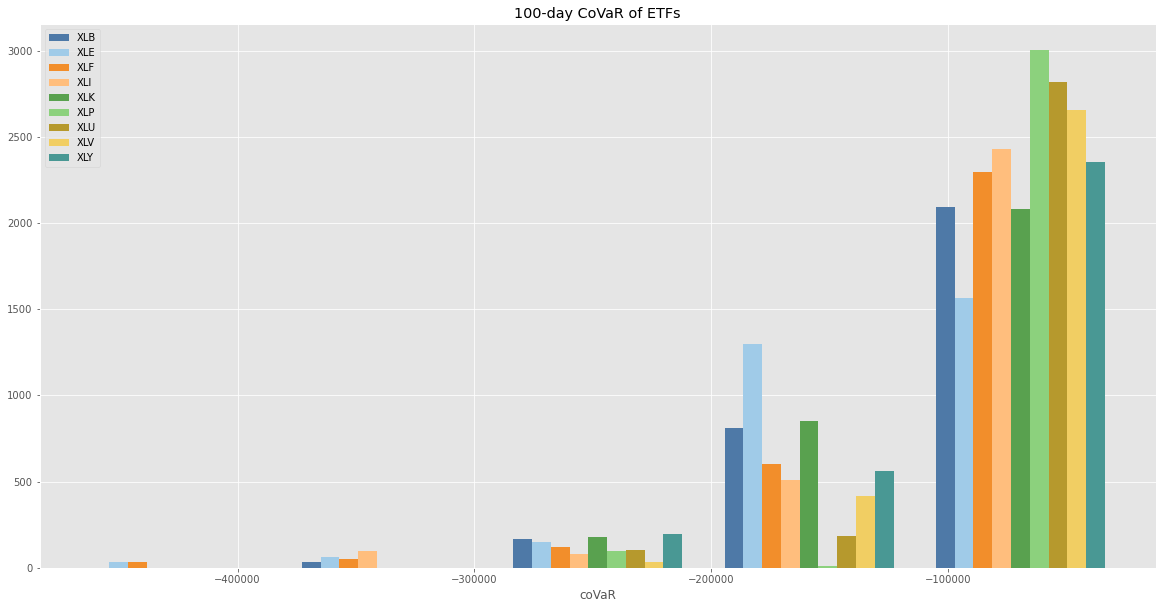

In [192]:
plt.figure(figsize=(20,10))
plt.style.use('ggplot')
plt.hist(CoVaR*np.sqrt(100)*1000000,bins = 5,label = return_etfs1.columns,
         color = ["#4E79A7", "#A0CBE8", "#F28E2B", "#FFBE7D", "#59A14F", "#8CD17D", 
                  "#B6992D", "#F1CE63", "#499894"])
plt.title("100-day CoVaR of ETFs")
plt.legend()
plt.xlabel("coVaR")

In [193]:
VaR_Port = np.zeros((len_day,num_etf))
CoVaR_Port = np.zeros((len_day,num_etf))
for i in range(len_day):
    VaR_Port[i] =  return_etfs1['port'].iloc[i:i+100].sort_values()[seq-1]
    CoVaR_Port[i] = alpha_matrix[i] + beta_matrix[i]*VaR_Port[i]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'coVaR')

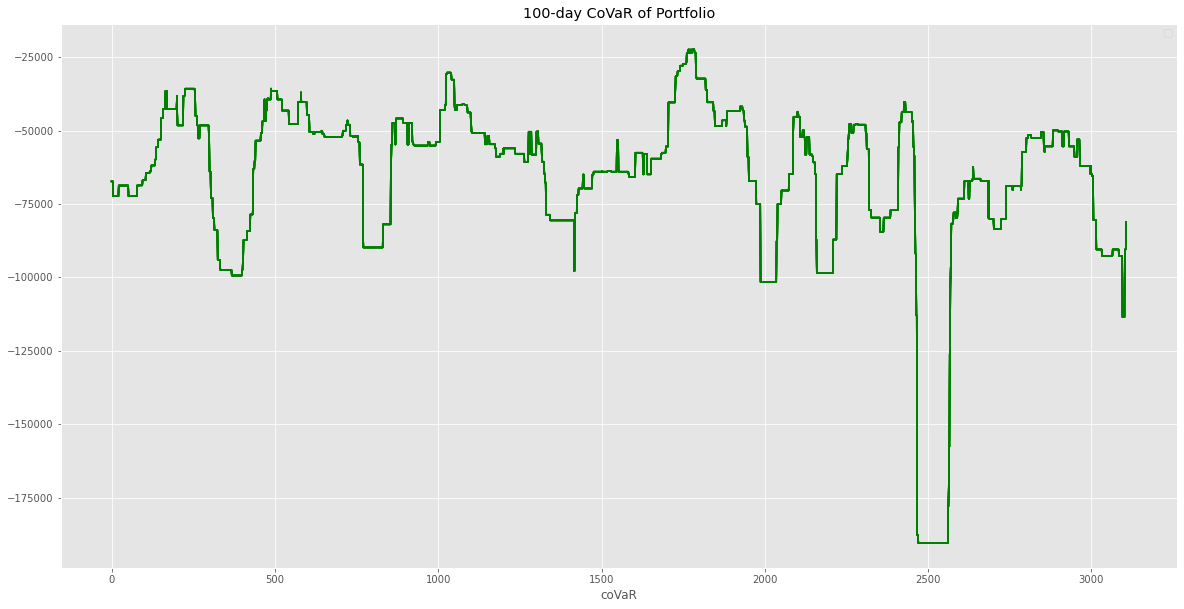

In [194]:
plt.figure(figsize=(20,10))
plt.plot(CoVaR_Port*np.sqrt(100)*1000000,color='g')
plt.title("100-day CoVaR of Portfolio")
plt.legend()
plt.xlabel("coVaR")